In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.sparse
import random
import seaborn as sns
sns.set(style="whitegrid")
import collections 
import itertools

## Problem 1.1 - Epidemics over symmetric graphs

You should simulate an epidemic on a symmetric k-regular graph with 500 nodes and k = 4. Let $\beta=3$ and $\rho$=0.7.
With one week being one unit of time, simulate the epidemic for 15 weeks. You can choose an initial configuration with 10 infected nodes selected at random from the node set V, or make a different choice of initial configuration (in the latter case, please briefly discuss your motivation).

$\rho$ is the probability that at one time step an infected I individual recovers becoming state R (mutation kernel).

$\beta$ is the probability that a susceptible S becomes and infected I based on the number of infected neighbors.

In [2]:
def draw_k_symmetric(n=8,k=4):
    G = nx.Graph()
    for i in range(n-2):
        G.add_edge(i, i+1)
        G.add_edge(i, i+2)
    G.add_edge(n-2, n-1)
    G.add_edge(n-2, 0)
    G.add_edge(n-1, 0)
    G.add_edge(n-1, 1)
    
    #nx.draw_circular(G, with_labels = True)
    
    return G

G = draw_k_symmetric(500)
print(G)

Graph with 500 nodes and 1000 edges


In [99]:
def simulate_epidemics(graph, n_infected=10, beta=0.3, rho=0.7, n_weeks=15, n_simulation=100,
                      flg_vaccine = False, 
                      vax_campaign = [0, 0, 5, 15, 25, 35, 45, 55, 60, 60, 60, 60, 60, 60, 60, 60]):
    
    # S=0, I=1, R=2
    G = graph
    # Number of agents, the number of nodes in the graph
    n_agents = len(G)

    tot_susceptible = np.zeros(n_weeks, dtype=int)
    tot_infected = np.zeros(n_weeks, dtype=int)
    tot_recovered = np.zeros(n_weeks, dtype=int)
    tot_new_infection = np.zeros(n_weeks, dtype=int)
    
    if flg_vaccine == True:
        fract_to_vax = [abs(prev-succ) for prev, succ in zip(vax_campaign, vax_campaign[1:])] 
        tot_vaccinated = np.zeros(n_weeks, dtype=int)
        tot_new_vaccinated = np.zeros(n_weeks, dtype=int)

    for i in range(n_simulation):
        # Initial configuration with random 10 infected nodes
        status = np.zeros(n_agents, dtype=int)
        initial_contagion = random.sample(list(np.arange(n_agents)), n_infected)
        for ix in initial_contagion:
            status[ix] = 1

        susceptible = []
        infected = []
        recovered = []
        new_infection = []
        
        if flg_vaccine == True:
            vaccinated = []
            new_vaccination = []         

        curr_state = status.copy()

        for week in range(n_weeks):
            prev_state = curr_state.copy()
            #print("week: ", week)
            #print(prev_state)
            #print("suscep: ", len(np.argwhere(prev_state == 0)))
            #print("infect: ", len(np.argwhere(prev_state == 1)))
            #print("recove: ", len(np.argwhere(prev_state == 2)))
            #print("vaccin: ", len(np.argwhere(prev_state == 3)))
            #print()
            
            if flg_vaccine == True:
                new_vax = 0
                not_vaccinated = np.argwhere(prev_state!=3).squeeze()
                number_to_vax = round(n_agents/100*fract_to_vax[week])
                people_to_vax = np.random.choice(not_vaccinated, size=number_to_vax, replace=False)
                for p in people_to_vax:
                    prev_state[p] = 3
                    new_vax += 1
                new_vaccination.append(new_vax)                
        
            curr_state = prev_state.copy()
            
            #print(curr_state)
            #print("suscep: ", len(np.argwhere(curr_state == 0)))
            #print("infect: ", len(np.argwhere(curr_state == 1)))
            #print("recove: ", len(np.argwhere(curr_state == 2)))
            #print("vaccin: ", len(np.argwhere(curr_state == 3)))
            #print(len(np.argwhere(curr_state == 0))+len(np.argwhere(curr_state == 1))+len(np.argwhere(curr_state == 2))+len(np.argwhere(curr_state == 3)))
            #print()
            
            susceptible.append(len(np.argwhere(curr_state == 0)))
            infected.append(len(np.argwhere(curr_state == 1)))
            recovered.append(len(np.argwhere(curr_state == 2)))
            if flg_vaccine == True:
                vaccinated.append(len(np.argwhere(curr_state == 3)))
            
            new_infect = 0      
            for node in range(n_agents):
                # If the node is susceptible
                if prev_state[node] == 0:
                    # compute the number of infected neighbors
                    neighbors = [i for i in G.neighbors(node)]
                    infect = sum(list(filter(lambda k:k==1, prev_state[neighbors])))
                    # compute the probability of infection
                    prob_infection = 1 - (1-beta)**infect
                    if np.random.rand() < prob_infection:
                        # infected!
                        curr_state[node] = 1
                        new_infect += 1
                # If the node is infected
                elif prev_state[node] == 1:
                    # probability of recover is rho = 0.7
                    if np.random.rand() < rho:
                        # recoved!
                        curr_state[node] = 2
            new_infection.append(new_infect)


        tot_susceptible = [sum(s) for s in zip(tot_susceptible, susceptible)]
        tot_infected = [sum(s) for s in zip(tot_infected, infected)]
        tot_recovered = [sum(s) for s in zip(tot_recovered, recovered)]
        tot_new_infection = [sum(s) for s in zip(tot_new_infection, new_infection)]
        if flg_vaccine == True:
            tot_vaccinated = [sum(s) for s in zip(tot_vaccinated, vaccinated)]
            tot_new_vaccinated = [sum(s) for s in zip(tot_new_vaccinated, new_vaccination)]

    avg_susceptible = [x/n_simulation for x in tot_susceptible]
    avg_infected = [x/n_simulation for x in tot_infected]
    avg_recovered = [x/n_simulation for x in tot_recovered]
    avg_new_infection = [x/n_simulation for x in tot_new_infection]
    if flg_vaccine == True:
        avg_vaccinated = [x/n_simulation for x in tot_vaccinated]
        avg_new_vaccinated = [x/n_simulation for x in tot_new_vaccinated]
        
    if flg_vaccine == True:
        return avg_susceptible, avg_infected, avg_recovered, avg_new_infection, avg_vaccinated, avg_new_vaccinated
    else:
        return avg_susceptible, avg_infected, avg_recovered, avg_new_infection

In [37]:
def epidemics_statistics(n_week, avg_susceptible, avg_infected, avg_recovered, avg_new_infection,
                         avg_vaccinated=[],avg_new_vaccinated=[],flg_vaccine = False):

    print("avg susceptible:")
    print(avg_susceptible)
    print("avg infected:")
    print(avg_infected)
    print("avg recovered:")
    print(avg_recovered)
    
    if flg_vaccine == True:
        print("avg vaccinated:")
        print(avg_vaccinated)
        
    print("avg new infection:")
    print(avg_new_infection)
    
    if flg_vaccine == True:
        print("avg new vaccinated:")
        print(avg_new_vaccinated)
           
    fig, (ax1, ax2)= plt.subplots(2,1,figsize=(15,12))
    x = list(np.arange(1, 16))
    ax1.set_xticks(x)
    ax2.set_xticks(x)               
    #plt.plot(x, avg_susceptible, label="average susceptible") 
    ax1.plot(x, avg_infected, label="average infected", color = 'red', linewidth=3) 
    ax1.plot(x, avg_recovered, label="average recovered", color = 'green', linewidth=3) 
    ax1.plot(x, avg_new_infection, label="average new_infection", color = 'magenta', linestyle='--'
             , linewidth=3) 
    if flg_vaccine == True:
        ax2.plot(x, avg_vaccinated, label="average vaccinated", color = 'darkviolet', 
                 linestyle='dashed', linewidth=3)
        ax2.plot(x, avg_new_vaccinated, label="average new vaccinated", color = 'darkorange',
                 linestyle='dashed', linewidth=3)

    ax1.tick_params(axis='x', labelsize=17)
    ax1.tick_params(axis='y', labelsize=17)
    ax1.legend(fontsize=17)

    if flg_vaccine == True:
        ax2.plot(x, avg_recovered, label="average recovered", color = 'green', linewidth=3) 
        ax2.plot(x, avg_infected, label="average infected", color = 'red', linewidth=3) 
        ax2.plot(x, avg_new_infection, label="average new_infection", color = 'magenta', linestyle='--'
             , linewidth=3)     
    else:
        ax2.plot(x, avg_susceptible, label="average susceptible", color = 'blue', linewidth=3)
    ax2.tick_params(axis='x', labelsize=17)
    ax2.tick_params(axis='y', labelsize=17)
    ax2.legend(fontsize=17)

    plt.show()

avg susceptible:
[490.0, 478.32, 467.96, 460.32, 454.95, 451.05, 448.08, 445.84, 444.11, 442.82, 441.94, 441.33, 440.96, 440.68, 440.45]
avg infected:
[10.0, 14.8, 14.61, 12.03, 9.06, 6.26, 4.83, 3.85, 2.94, 2.32, 1.51, 1.06, 0.6, 0.44, 0.35]
avg recovered:
[0.0, 6.88, 17.43, 27.65, 35.99, 42.69, 47.09, 50.31, 52.95, 54.86, 56.55, 57.61, 58.44, 58.88, 59.2]
avg new infection:
[11.68, 10.36, 7.64, 5.37, 3.9, 2.97, 2.24, 1.73, 1.29, 0.88, 0.61, 0.37, 0.28, 0.23, 0.14]


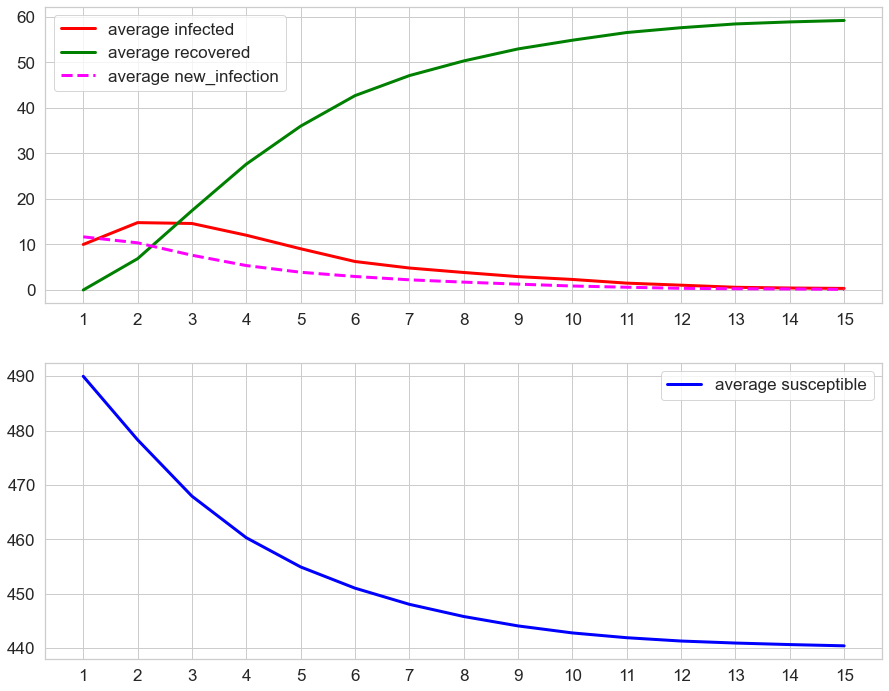

In [62]:
avg_susceptible, avg_infected, avg_recovered, avg_new_infection = simulate_epidemics(G)
epidemics_statistics(15, avg_susceptible, avg_infected, avg_recovered, avg_new_infection)

## Problem 1.2 - Preferential Attachment Random Graph

In [6]:
def create_random_graph(n=40, k=7):
    
    GPA = nx.complete_graph(k+1)
    
    for node in range(k+1, n):
        if k % 2 == 1:
            # if k is uneven take alternatively the floor and ceil of the number
            if node % 2 == 0:
                d = int(np.floor(k/2))
            else:
                d = int(np.ceil(k/2))
        else:
            # k is even
            d = int(k/2)
        
        deg_PA = [d for n, d in GPA.degree()]
        probabilities = np.array(deg_PA)/sum(deg_PA)
        #print(deg_PA)
        # replace=False guarantees no neighbor is chosen twice
        neighbors = np.random.choice(np.arange(len(GPA)), p=probabilities, size=d, replace=False)
        GPA.add_node(node)
        # add the new links 
        for neigh in neighbors:
            GPA.add_edge(node,neigh)   

    #nx.draw_circular(GPA, with_labels = True)
    deg_PA = [d for n, d in GPA.degree()]
    #print()
    #print("number of nodes: ", len(GPA))
    #print("average degree: ", sum(deg_PA)/len(GPA))
    
    return GPA

In [7]:
create_random_graph(910, 7)    

number of nodes:  910
average degree:  7.0


## Problem 2 - Simulate a pandemic without vaccination

In [7]:
G2 = create_random_graph(500, 6)  

avg susceptible:
[490.0, 472.98, 414.78, 304.97, 199.54, 138.5, 110.37, 98.34, 93.65, 91.78, 91.07, 90.76, 90.62, 90.6, 90.58]
avg infected:
[10.0, 20.06, 64.04, 129.14, 143.78, 105.31, 60.7, 29.81, 13.67, 5.95, 2.39, 0.98, 0.36, 0.16, 0.08]
avg recovered:
[0.0, 6.96, 21.18, 65.89, 156.68, 256.19, 328.93, 371.85, 392.68, 402.27, 406.54, 408.26, 409.02, 409.24, 409.34]
avg new infection:
[17.02, 58.2, 109.81, 105.43, 61.04, 28.13, 12.03, 4.69, 1.87, 0.71, 0.31, 0.14, 0.02, 0.02, 0.01]


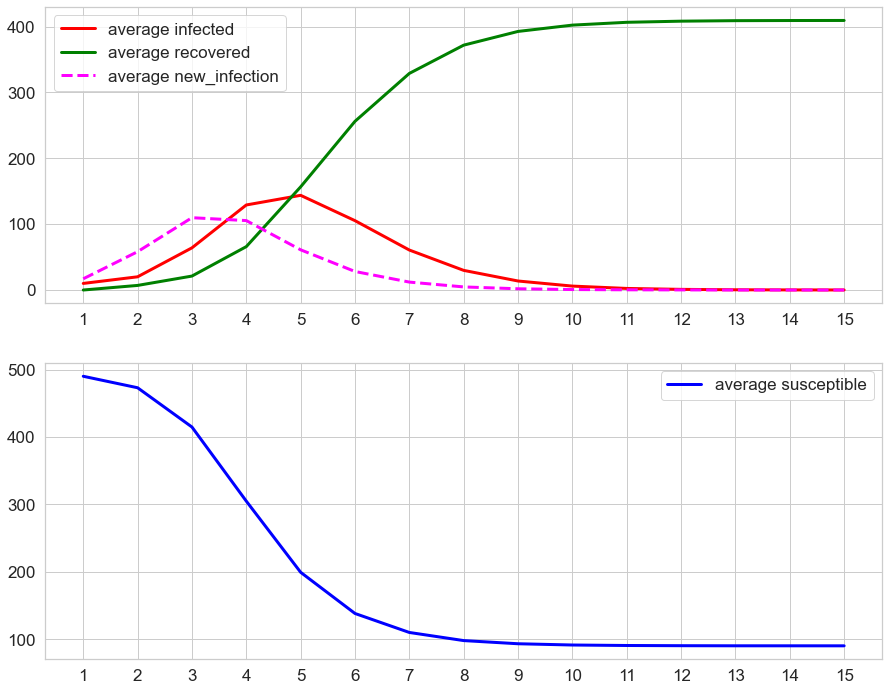

In [95]:
avg_susceptible, avg_infected, avg_recovered, avg_new_infection = simulate_epidemics(G2)
epidemics_statistics(15, avg_susceptible, avg_infected, avg_recovered, avg_new_infection)

## Problem 3 - Simulate a pandemic with vaccination

In [17]:
G3 = create_random_graph(500, 6)  

avg susceptible:
[490.0, 448.24, 354.42, 245.09, 163.82, 114.4, 84.92, 72.43, 71.33, 70.9, 70.73, 70.6, 70.53, 70.51, 70.49]
avg infected:
[10.0, 20.32, 52.35, 80.96, 69.92, 42.19, 19.05, 7.88, 3.33, 1.24, 0.57, 0.27, 0.15, 0.08, 0.07]
avg recovered:
[0.0, 6.44, 18.23, 48.95, 91.26, 118.41, 121.03, 119.69, 125.34, 127.86, 128.7, 129.13, 129.32, 129.41, 129.44]
avg vaccinated:
[0.0, 25.0, 75.0, 125.0, 175.0, 225.0, 275.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0]
avg new infection:
[18.27, 52.51, 77.14, 56.32, 27.84, 10.41, 3.36, 1.1, 0.43, 0.17, 0.13, 0.07, 0.02, 0.02, 0.05]
avg new vaccinated:
[0.0, 25.0, 50.0, 50.0, 50.0, 50.0, 50.0, 25.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


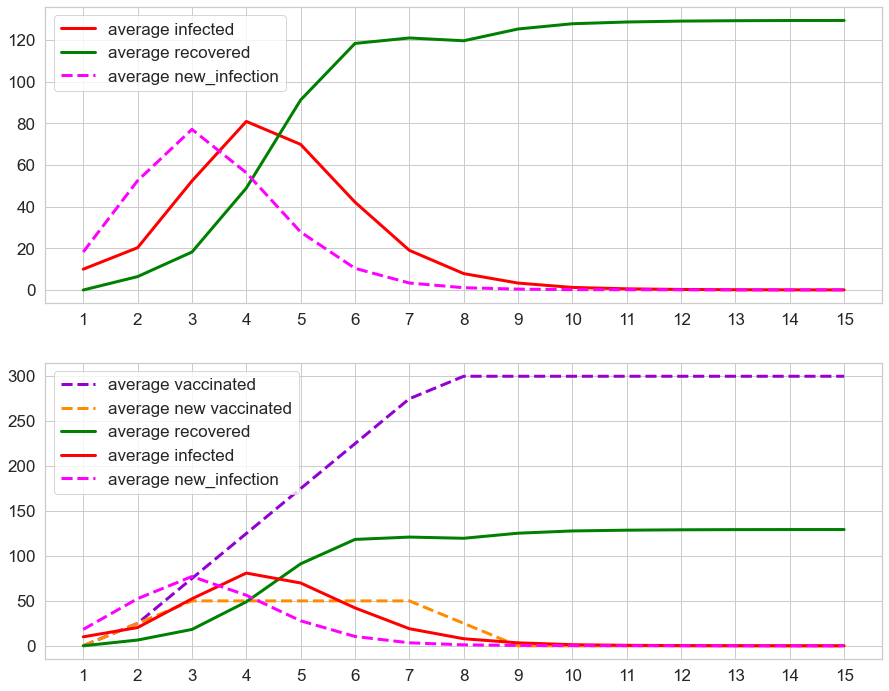

In [100]:
vax_campaign = [0, 0, 5, 15, 25, 35, 45, 55, 60, 60, 60, 60, 60, 60, 60, 60]
(avg_susceptible, avg_infected, avg_recovered, avg_new_infection, 
 avg_vaccinated, avg_new_vaccinated) = simulate_epidemics(G3,n_infected=10, 
                                                          beta=0.3, rho=0.7, 
                                                          n_weeks=15, n_simulation=100,
                                                          flg_vaccine = True, 
                                                          vax_campaign = vax_campaign)

epidemics_statistics(15, avg_susceptible, avg_infected, avg_recovered, 
                     avg_new_infection, avg_vaccinated, avg_new_vaccinated, flg_vaccine = True)

## Problem 4 - The H1N1 pandemic in Sweden 2009

In [112]:
k_0 = int(np.random.rand()*20)
#k_0 = 10
k_delta = 4
beta_0 = 0.3
beta_delta = 0.2
rho_0 = 0.6
rho_delta = 0.2
n_weeks=15
n_simulation = 10

vax_campaign = [0, 5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60, 60]
true_new_infection = [1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0]

best_rmse_k_b_r = (10000000, 10000000, 10000000, 10000000)

alpha = 0.5
cnt = 0

print("k_0: ", k_0)
print()

stopping_condition = True
while(stopping_condition):
    
    prev_best_rmse_k_b_r = best_rmse_k_b_r

    k = np.linspace(max(k_0-k_delta,1), k_0+k_delta, num=3, dtype = int)  
    if cnt <= 2:
        b = [0.2, 0.4, 0.6, 0.8]#np.linspace(max(beta_0-beta_delta, 0.01), beta_0+beta_delta, num=3)
        r = [0.2, 0.4, 0.6, 0.8]#np.linspace(max(rho_0-rho_delta, 0.01), rho_0+rho_delta, num=3)
    else:
        b = np.linspace(max(beta_0-beta_delta, 0.01), beta_0+beta_delta, num=5)
        r = np.linspace(max(rho_0-rho_delta, 0.01), rho_0+rho_delta, num=5)
        
    print("k: ", k)  
    print("b: ", b)  
    print("r: ", r)  

    combinations = [k, b, r]

    # Iterate over all the possible combinations of k, beta e rho
    for c in list(itertools.product(*combinations)):

        k_c, b_c, r_c = c

        # generate a random graph
        G = create_random_graph(934, k_c) 

        # simulate epidemics over the random graph
        (avg_susceptible, avg_infected, avg_recovered, avg_new_infection, 
         avg_vaccinated, avg_new_vaccinated) = simulate_epidemics(G,n_infected=1, 
                                                              beta=b_c, rho=r_c, 
                                                              n_weeks=n_weeks, n_simulation=n_simulation,
                                                              flg_vaccine = True, 
                                                              vax_campaign = vax_campaign)

        print("parameters set: [{}, {}, {}]".format(k_c, b_c, r_c))
        print("avg new infection: ", avg_new_infection)

        # compute RMSE
        sqrt_diff = [(x-y)**2 for x,y in zip(avg_new_infection,true_new_infection)]
        rmse = (sum(sqrt_diff)/n_weeks)**0.5
        print("RMSE = ", rmse)
        print()

        # compare with the best RMSE
        if rmse < best_rmse_k_b_r[0]:
            best_rmse_k_b_r = (rmse, k_c, b_c, r_c)
            
            # I found a different k
            if best_rmse_k_b_r[1] != prev_best_rmse_k_b_r[1]:
                cnt = 0
                k_delta = 4
                beta_delta = 0.2
                rho_delta = 0.2

    if (best_rmse_k_b_r[1]==prev_best_rmse_k_b_r[1] 
        #and 
        #best_rmse_k_b_r[2]==prev_best_rmse_k_b_r[2] and 
        #best_rmse_k_b_r[3]==prev_best_rmse_k_b_r[3] 
       ):
        cnt+=1
        
        if cnt == 6:
            stopping_condition = False
           
        if cnt > 2 and cnt % 2 ==1:
            k_delta = max(k_delta*alpha,1)
            beta_delta = beta_delta*alpha
            rho_delta = rho_delta*alpha
    
    print()
    print("##########################")
    print("counter same node: ", cnt)
    print("chosen param: ", best_rmse_k_b_r[1], best_rmse_k_b_r[2], best_rmse_k_b_r[3]) 
    print("best rmse: ", best_rmse_k_b_r[0]) 
    print("k_delta: ", k_delta)
    print("beta_delta: ", beta_delta)
    print("rho_delta: ", rho_delta)
    print("##########################")
    print()
    k_0, beta_0, rho_0 = best_rmse_k_b_r[1], best_rmse_k_b_r[2], best_rmse_k_b_r[3]    

print(best_rmse_k_b_r)

k_0:  15

k:  [11 15 19]
b:  [0.2, 0.4, 0.6, 0.8]
r:  [0.2, 0.4, 0.6, 0.8]
parameters set: [11, 0.2, 0.2]
avg new infection:  [1.1, 4.9, 25.1, 58.9, 86.7, 72.1, 47.8, 26.3, 10.3, 7.6, 4.1, 4.1, 2.9, 1.1, 1.6]
RMSE =  29.25989291390748

parameters set: [11, 0.2, 0.4]
avg new infection:  [1.6, 6.2, 18.8, 42.8, 67.7, 70.1, 57.6, 37.1, 18.8, 14.0, 8.3, 5.6, 3.4, 2.8, 1.5]
RMSE =  24.2477352894382

parameters set: [11, 0.2, 0.6]
avg new infection:  [2.4, 10.8, 38.5, 73.0, 83.6, 60.9, 31.8, 15.4, 7.8, 5.0, 1.8, 1.3, 1.4, 0.3, 0.3]
RMSE =  30.372279027648442

parameters set: [11, 0.2, 0.8]
avg new infection:  [2.3, 9.3, 25.9, 46.4, 55.5, 42.1, 25.8, 13.7, 6.9, 2.3, 1.9, 0.8, 0.2, 0.2, 0.1]
RMSE =  19.29417874213187

parameters set: [11, 0.4, 0.2]
avg new infection:  [3.9, 24.2, 138.3, 274.2, 168.7, 51.1, 12.9, 3.3, 0.6, 0.2, 0.2, 0.1, 0.0, 0.0, 0.0]
RMSE =  89.24603819404722

parameters set: [11, 0.4, 0.4]
avg new infection:  [3.3, 30.6, 147.0, 236.8, 142.6, 38.8, 7.5, 2.0, 0.2, 0.3, 0.0, 0.0

parameters set: [7, 0.2, 0.4]
avg new infection:  [1.4, 2.4, 4.7, 11.1, 15.4, 17.2, 16.9, 11.5, 10.2, 10.8, 6.9, 7.0, 5.7, 3.8, 3.5]
RMSE =  7.87633586553206

parameters set: [7, 0.2, 0.6]
avg new infection:  [1.8, 5.6, 11.6, 18.7, 29.1, 27.7, 21.9, 15.9, 8.6, 5.8, 3.7, 2.4, 1.6, 1.0, 0.4]
RMSE =  9.102893312934448

parameters set: [7, 0.2, 0.8]
avg new infection:  [2.8, 7.5, 17.0, 23.4, 23.5, 20.0, 10.2, 3.7, 1.8, 1.0, 0.2, 0.0, 0.0, 0.0, 0.0]
RMSE =  12.45447710664723

parameters set: [7, 0.4, 0.2]
avg new infection:  [2.5, 12.3, 58.5, 132.2, 153.3, 109.6, 47.7, 21.2, 7.8, 3.8, 2.7, 0.7, 0.5, 0.1, 0.1]
RMSE =  57.29301295387888

parameters set: [7, 0.4, 0.4]
avg new infection:  [2.4, 12.6, 58.0, 139.3, 150.0, 81.3, 32.1, 9.9, 3.6, 1.5, 0.5, 0.5, 0.3, 0.0, 0.0]
RMSE =  55.3150491879621

parameters set: [7, 0.4, 0.6]
avg new infection:  [1.5, 8.0, 36.8, 90.5, 104.5, 76.3, 36.6, 11.4, 6.4, 2.1, 2.1, 0.8, 0.3, 0.1, 0.0]
RMSE =  38.03955835705772

parameters set: [7, 0.4, 0.8]
avg new inf

parameters set: [3, 0.2, 0.8]
avg new infection:  [0.5, 0.2, 0.4, 0.1, 0.0, 0.1, 0.6, 0.3, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
RMSE =  13.436567021874795

parameters set: [3, 0.4, 0.2]
avg new infection:  [0.7, 6.8, 13.8, 16.6, 14.2, 8.9, 8.2, 5.9, 2.8, 5.2, 3.4, 3.0, 2.2, 0.8, 0.5]
RMSE =  11.071284177245806

parameters set: [3, 0.4, 0.4]
avg new infection:  [0.7, 1.5, 7.6, 10.8, 12.8, 12.2, 14.6, 10.8, 6.5, 5.9, 2.2, 1.7, 1.7, 1.2, 0.3]
RMSE =  8.003457586151958

parameters set: [3, 0.4, 0.6]
avg new infection:  [0.9, 3.9, 4.8, 5.4, 5.8, 2.9, 2.3, 2.9, 0.9, 0.4, 0.4, 0.4, 0.0, 0.0, 0.0]
RMSE =  12.201256765869108

parameters set: [3, 0.4, 0.8]
avg new infection:  [1.7, 2.9, 5.2, 4.7, 5.1, 3.8, 2.4, 2.8, 0.5, 0.4, 0.2, 0.0, 0.0, 0.0, 0.0]
RMSE =  12.179025686263522

parameters set: [3, 0.6, 0.2]
avg new infection:  [1.4, 9.6, 38.5, 58.2, 51.7, 40.3, 30.8, 21.9, 13.1, 9.8, 6.2, 2.9, 2.5, 1.0, 0.7]
RMSE =  21.136824107072787

parameters set: [3, 0.6, 0.4]
avg new infection:  [1.4, 7.9, 1

parameters set: [3, 0.4, 0.4]
avg new infection:  [0.7, 2.5, 5.4, 10.6, 17.9, 17.4, 8.8, 6.0, 6.7, 5.0, 4.2, 3.4, 2.3, 2.4, 1.8]
RMSE =  9.879439930144487

parameters set: [3, 0.4, 0.6]
avg new infection:  [0.9, 3.5, 8.6, 17.4, 16.5, 14.2, 9.2, 7.4, 4.7, 3.1, 1.2, 0.2, 0.7, 0.3, 0.0]
RMSE =  10.123339369990518

parameters set: [3, 0.4, 0.8]
avg new infection:  [2.4, 3.6, 8.4, 9.4, 10.2, 13.1, 6.4, 1.7, 0.7, 0.2, 0.2, 0.0, 0.1, 0.1, 0.0]
RMSE =  11.373448612155125

parameters set: [3, 0.6, 0.2]
avg new infection:  [2.1, 8.8, 22.8, 50.5, 61.0, 60.1, 40.5, 21.4, 10.5, 6.3, 3.9, 1.8, 1.0, 1.4, 1.0]
RMSE =  22.09481085383323

parameters set: [3, 0.6, 0.4]
avg new infection:  [3.1, 22.2, 37.7, 53.1, 54.0, 30.4, 19.3, 7.1, 2.6, 1.1, 2.2, 1.3, 1.7, 1.1, 0.4]
RMSE =  21.88510909271416

parameters set: [3, 0.6, 0.6]
avg new infection:  [1.3, 5.3, 11.8, 16.9, 20.9, 19.3, 19.0, 9.8, 7.4, 3.7, 1.8, 1.2, 0.2, 0.0, 0.2]
RMSE =  8.71925073233551

parameters set: [3, 0.6, 0.8]
avg new infection:  [1.2,

parameters set: [3, 0.4, 0.8]
avg new infection:  [1.3, 5.1, 12.4, 12.8, 8.3, 6.8, 5.3, 4.4, 2.4, 1.1, 0.6, 0.2, 0.1, 0.1, 0.0]
RMSE =  11.4782983640143

parameters set: [3, 0.6, 0.2]
avg new infection:  [2.1, 7.5, 16.2, 32.8, 48.6, 48.5, 37.8, 26.5, 19.6, 11.4, 7.3, 3.1, 2.5, 1.0, 0.7]
RMSE =  15.711566864362489

parameters set: [3, 0.6, 0.4]
avg new infection:  [1.2, 7.2, 14.6, 23.9, 31.8, 25.3, 20.5, 10.8, 5.8, 4.3, 2.0, 1.7, 1.9, 0.5, 0.1]
RMSE =  11.048257781206955

parameters set: [3, 0.6, 0.6]
avg new infection:  [1.7, 6.1, 28.2, 49.2, 57.9, 49.6, 32.1, 16.6, 6.8, 3.2, 1.9, 0.6, 0.2, 0.2, 0.2]
RMSE =  20.678313922239084

parameters set: [3, 0.6, 0.8]
avg new infection:  [0.9, 1.6, 2.9, 11.0, 18.5, 15.6, 10.7, 8.0, 5.1, 1.9, 1.3, 2.2, 3.3, 2.2, 2.2]
RMSE =  9.423375191511798

parameters set: [3, 0.8, 0.2]
avg new infection:  [2.1, 20.7, 73.6, 133.2, 112.3, 54.2, 18.5, 8.1, 3.6, 1.0, 0.4, 0.6, 0.2, 0.1, 0.0]
RMSE =  48.177048477464865

parameters set: [3, 0.8, 0.4]
avg new infecti

parameters set: [6, 0.15000000000000002, 0.5]
avg new infection:  [1.6, 3.9, 4.2, 4.8, 8.9, 4.6, 3.7, 3.2, 2.0, 1.5, 0.6, 0.6, 0.4, 0.5, 0.3]
RMSE =  11.645371040317551

parameters set: [6, 0.2, 0.30000000000000004]
avg new infection:  [1.0, 1.1, 2.9, 6.1, 10.4, 11.0, 13.5, 12.7, 9.7, 10.4, 7.8, 7.3, 6.2, 5.2, 4.6]
RMSE =  8.150051124584024

parameters set: [6, 0.2, 0.35000000000000003]
avg new infection:  [1.0, 2.2, 2.8, 5.0, 7.8, 7.3, 6.3, 6.8, 6.2, 4.8, 4.2, 5.9, 5.6, 6.3, 4.3]
RMSE =  10.416685333316607

parameters set: [6, 0.2, 0.4]
avg new infection:  [1.2, 1.0, 3.5, 6.7, 9.6, 13.6, 11.9, 5.7, 4.5, 4.6, 3.4, 2.7, 2.5, 1.9, 1.6]
RMSE =  9.253755994189603

parameters set: [6, 0.2, 0.45]
avg new infection:  [1.2, 3.3, 7.5, 12.3, 13.8, 14.7, 11.6, 9.2, 5.9, 4.3, 6.3, 4.0, 3.6, 2.2, 2.1]
RMSE =  9.005923976287312

parameters set: [6, 0.2, 0.5]
avg new infection:  [1.5, 4.0, 8.1, 15.7, 16.3, 18.6, 15.6, 12.0, 5.3, 4.7, 2.5, 2.8, 1.7, 1.6, 1.1]
RMSE =  8.253039844000917

parameters set:

parameters set: [8, 0.15000000000000002, 0.45]
avg new infection:  [1.3, 2.3, 4.9, 10.2, 18.6, 24.4, 20.0, 13.9, 9.8, 9.6, 8.4, 6.5, 4.0, 3.7, 3.0]
RMSE =  7.45591487791181

parameters set: [8, 0.15000000000000002, 0.5]
avg new infection:  [0.9, 1.1, 2.4, 5.0, 8.0, 9.9, 7.7, 6.3, 4.9, 5.3, 5.4, 4.7, 3.4, 2.0, 1.7]
RMSE =  9.976539146083342

parameters set: [8, 0.2, 0.30000000000000004]
avg new infection:  [1.3, 2.8, 9.0, 21.4, 37.4, 48.1, 41.2, 29.8, 20.6, 16.5, 10.2, 9.2, 6.4, 5.3, 3.4]
RMSE =  12.991894909262978

parameters set: [8, 0.2, 0.35000000000000003]
avg new infection:  [1.0, 3.7, 14.0, 29.6, 40.3, 43.9, 31.2, 21.3, 11.1, 6.0, 3.9, 2.1, 1.7, 0.9, 1.0]
RMSE =  13.158546018969318

parameters set: [8, 0.2, 0.4]
avg new infection:  [1.2, 9.6, 21.9, 34.9, 45.2, 39.7, 32.2, 21.1, 13.1, 7.9, 4.3, 3.1, 3.1, 1.1, 1.1]
RMSE =  14.866405079910878

parameters set: [8, 0.2, 0.45]
avg new infection:  [1.0, 3.0, 9.4, 16.8, 32.4, 33.3, 27.9, 21.2, 14.8, 11.1, 6.6, 4.9, 2.7, 2.5, 1.6]
RMSE = 

parameters set: [12, 0.2, 0.2]
avg new infection:  [4.0, 17.5, 47.5, 86.0, 100.7, 93.8, 60.9, 32.0, 17.3, 10.2, 5.4, 4.0, 3.2, 3.7, 5.3]
RMSE =  40.05375554593268

parameters set: [12, 0.2, 0.4]
avg new infection:  [2.9, 14.0, 35.7, 58.9, 71.6, 63.8, 42.4, 24.5, 16.3, 11.2, 6.2, 4.8, 3.8, 1.5, 1.5]
RMSE =  26.470700784074456

parameters set: [12, 0.2, 0.6]
avg new infection:  [5.3, 21.3, 56.4, 84.4, 88.5, 62.3, 37.9, 19.4, 12.0, 5.6, 4.8, 2.0, 1.3, 0.3, 0.3]
RMSE =  34.82190881231718

parameters set: [12, 0.2, 0.8]
avg new infection:  [2.5, 8.1, 32.2, 75.1, 93.9, 72.8, 33.5, 15.4, 5.6, 3.3, 2.1, 1.5, 1.0, 0.5, 0.7]
RMSE =  33.22009432055645

parameters set: [12, 0.4, 0.2]
avg new infection:  [3.2, 25.3, 113.2, 195.3, 112.2, 27.6, 5.0, 0.8, 0.1, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0]
RMSE =  64.15260451974392

parameters set: [12, 0.4, 0.4]
avg new infection:  [4.4, 35.6, 176.0, 280.1, 142.4, 34.6, 7.8, 1.8, 0.1, 0.1, 0.2, 0.1, 0.1, 0.0, 0.0]
RMSE =  91.91822815234563

parameters set: [12, 0.4, 

parameters set: [12, 0.2, 0.6]
avg new infection:  [2.5, 6.3, 25.0, 60.3, 80.5, 58.2, 35.3, 15.9, 7.4, 2.4, 1.2, 0.6, 0.1, 0.3, 0.0]
RMSE =  26.773170650236157

parameters set: [12, 0.2, 0.8]
avg new infection:  [1.6, 3.7, 10.3, 29.4, 52.4, 51.2, 38.8, 27.3, 13.7, 7.7, 4.6, 2.6, 1.2, 0.7, 0.1]
RMSE =  15.93166657948879

parameters set: [12, 0.4, 0.2]
avg new infection:  [3.0, 31.1, 135.4, 243.5, 145.9, 42.2, 10.5, 2.5, 0.4, 0.2, 0.2, 0.0, 0.0, 0.0, 0.0]
RMSE =  80.13904999020973

parameters set: [12, 0.4, 0.4]
avg new infection:  [7.1, 71.1, 273.8, 272.2, 83.1, 14.9, 2.7, 0.6, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0]
RMSE =  102.41439351966109

parameters set: [12, 0.4, 0.6]
avg new infection:  [2.8, 26.0, 132.8, 236.1, 114.4, 24.7, 4.0, 1.0, 0.3, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
RMSE =  74.88027332571198

parameters set: [12, 0.4, 0.8]
avg new infection:  [4.5, 27.5, 127.0, 235.3, 151.2, 65.2, 16.9, 3.6, 0.3, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
RMSE =  78.74690681755908

parameters set: [12, 0.6, 0.

parameters set: [12, 0.4, 0.2]
avg new infection:  [3.7, 26.2, 134.1, 265.6, 153.7, 29.5, 6.8, 1.0, 0.2, 0.1, 0.0, 0.0, 0.1, 0.0, 0.0]
RMSE =  85.14440283032899

parameters set: [12, 0.4, 0.4]
avg new infection:  [3.5, 27.5, 129.5, 275.8, 187.2, 40.5, 7.3, 2.0, 0.7, 0.3, 0.1, 0.0, 0.0, 0.0, 0.0]
RMSE =  90.97741844362625

parameters set: [12, 0.4, 0.6]
avg new infection:  [2.7, 18.0, 114.4, 216.2, 135.3, 34.7, 7.0, 1.2, 0.4, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
RMSE =  70.92318379768352

parameters set: [12, 0.4, 0.8]
avg new infection:  [3.7, 28.1, 121.7, 222.0, 146.0, 43.8, 11.0, 2.3, 0.6, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0]
RMSE =  74.39879927346497

parameters set: [12, 0.6, 0.2]
avg new infection:  [5.7, 81.7, 373.4, 268.5, 24.2, 1.7, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
RMSE =  119.99686940360846

parameters set: [12, 0.6, 0.4]
avg new infection:  [10.4, 117.7, 352.2, 193.1, 14.7, 0.8, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
RMSE =  107.60379485253605

parameters set: [12, 0.6, 0

parameters set: [8, 0.4, 0.8]
avg new infection:  [2.3, 15.6, 63.2, 131.4, 125.7, 70.6, 33.5, 12.8, 3.7, 1.5, 0.3, 0.1, 0.1, 0.0, 0.0]
RMSE =  49.57918918255925

parameters set: [8, 0.6, 0.2]
avg new infection:  [3.5, 45.2, 193.1, 236.9, 117.8, 28.3, 5.5, 1.1, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0]
RMSE =  83.98767766761979

parameters set: [8, 0.6, 0.4]
avg new infection:  [5.8, 73.2, 283.3, 274.8, 71.9, 12.1, 2.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
RMSE =  104.17539056802235

parameters set: [8, 0.6, 0.6]
avg new infection:  [7.4, 47.2, 156.4, 213.6, 102.9, 23.3, 3.6, 0.6, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
RMSE =  73.11604475079325

parameters set: [8, 0.6, 0.8]
avg new infection:  [5.9, 58.4, 155.6, 201.0, 129.8, 40.2, 9.4, 1.6, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
RMSE =  73.89466827857068

parameters set: [8, 0.8, 0.2]
avg new infection:  [13.9, 110.4, 279.4, 234.9, 37.0, 1.4, 0.2, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
RMSE =  98.23812905384547

parameters set: [8, 0.8, 0.4]
avg

parameters set: [8, 0.6, 0.6]
avg new infection:  [2.2, 21.5, 117.9, 215.4, 130.8, 35.2, 6.3, 0.6, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
RMSE =  70.7187056819717

parameters set: [8, 0.6, 0.8]
avg new infection:  [3.0, 24.9, 137.9, 239.6, 148.9, 49.8, 22.1, 7.2, 2.5, 0.8, 0.1, 0.2, 0.1, 0.0, 0.0]
RMSE =  79.75104179047861

parameters set: [8, 0.8, 0.2]
avg new infection:  [4.4, 69.4, 314.4, 287.9, 58.8, 3.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
RMSE =  111.57333612173355

parameters set: [8, 0.8, 0.4]
avg new infection:  [4.4, 67.2, 364.5, 269.6, 37.5, 2.9, 0.6, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
RMSE =  117.87650034393342

parameters set: [8, 0.8, 0.6]
avg new infection:  [4.6, 50.7, 298.6, 273.0, 37.4, 1.9, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
RMSE =  104.90681261640417

parameters set: [8, 0.8, 0.8]
avg new infection:  [4.7, 38.5, 232.6, 285.3, 82.4, 6.5, 0.3, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
RMSE =  96.7987224433601


##########################
counter same

parameters set: [8, 0.8, 0.4]
avg new infection:  [8.8, 90.1, 299.2, 297.8, 46.6, 1.7, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
RMSE =  111.19592918208232

parameters set: [8, 0.8, 0.6]
avg new infection:  [4.4, 59.7, 273.6, 272.9, 49.7, 3.2, 0.4, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
RMSE =  100.87633022666914

parameters set: [8, 0.8, 0.8]
avg new infection:  [5.6, 73.9, 330.6, 274.1, 49.1, 3.6, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
RMSE =  112.31323756945721


##########################
counter same node:  3
chosen param:  4 0.4 0.2
best rmse:  4.451741232371891
k_delta:  1
beta_delta:  0.1
rho_delta:  0.1
##########################

k:  [3 4 5]
b:  [0.3  0.35 0.4  0.45 0.5 ]
r:  [0.1  0.15 0.2  0.25 0.3 ]
parameters set: [3, 0.30000000000000004, 0.1]
avg new infection:  [1.1, 3.9, 5.4, 7.6, 10.4, 9.4, 6.3, 6.7, 4.6, 3.7, 3.4, 3.2, 2.0, 2.0, 1.7]
RMSE =  10.179652908293747

parameters set: [3, 0.30000000000000004, 0.15000000000000002]
avg new infection:  [1.0, 2.9, 7.0,

parameters set: [4, 0.45, 0.30000000000000004]
avg new infection:  [4.1, 16.8, 49.5, 75.6, 80.5, 68.0, 43.1, 20.6, 11.4, 7.4, 4.7, 3.1, 1.5, 0.5, 1.0]
RMSE =  32.06722106242864

parameters set: [4, 0.5, 0.1]
avg new infection:  [3.5, 13.6, 40.1, 72.9, 82.2, 73.4, 48.1, 30.8, 16.1, 13.4, 13.0, 8.3, 5.2, 3.5, 1.8]
RMSE =  31.87461895197076

parameters set: [4, 0.5, 0.15000000000000002]
avg new infection:  [1.0, 6.4, 18.8, 37.9, 69.9, 76.8, 52.5, 33.6, 19.2, 12.4, 7.7, 5.5, 2.1, 1.8, 1.0]
RMSE =  24.75191575077237

parameters set: [4, 0.5, 0.2]
avg new infection:  [1.3, 5.2, 21.3, 45.2, 68.5, 70.5, 52.7, 30.6, 16.1, 7.9, 5.3, 2.4, 2.2, 0.9, 0.9]
RMSE =  24.26264618709179

parameters set: [4, 0.5, 0.25]
avg new infection:  [1.6, 6.4, 22.5, 44.9, 66.9, 58.4, 41.4, 23.3, 11.9, 7.2, 3.7, 2.7, 1.5, 1.0, 1.0]
RMSE =  22.0198092634791

parameters set: [4, 0.5, 0.30000000000000004]
avg new infection:  [2.0, 11.4, 33.8, 59.2, 71.2, 57.7, 38.5, 22.1, 14.7, 8.5, 4.1, 3.4, 2.5, 1.0, 0.6]
RMSE =  25.4

parameters set: [3, 0.45, 0.1]
avg new infection:  [2.0, 3.8, 11.3, 21.5, 27.7, 33.5, 30.1, 21.8, 16.4, 10.8, 9.1, 7.1, 4.1, 2.9, 2.2]
RMSE =  9.05998528328459

parameters set: [3, 0.45, 0.15000000000000002]
avg new infection:  [1.2, 5.2, 7.7, 13.2, 25.6, 32.0, 28.2, 18.3, 12.6, 10.1, 6.9, 5.6, 6.1, 3.6, 2.8]
RMSE =  7.992705007275906

parameters set: [3, 0.45, 0.2]
avg new infection:  [3.5, 11.4, 19.9, 25.6, 28.3, 18.1, 15.4, 8.1, 3.3, 1.4, 1.2, 0.9, 0.7, 0.1, 0.2]
RMSE =  12.238436719341788

parameters set: [3, 0.45, 0.25]
avg new infection:  [0.9, 4.4, 11.0, 18.7, 23.2, 21.8, 16.0, 10.4, 5.8, 4.4, 3.2, 2.3, 1.5, 1.1, 0.9]
RMSE =  9.464671151181111

parameters set: [3, 0.45, 0.30000000000000004]
avg new infection:  [0.9, 5.0, 7.6, 11.9, 12.7, 10.7, 9.5, 5.4, 5.1, 4.0, 1.8, 1.9, 0.5, 0.9, 0.4]
RMSE =  9.988827091639273

parameters set: [3, 0.5, 0.1]
avg new infection:  [1.0, 6.2, 18.2, 30.2, 39.5, 34.6, 24.4, 20.1, 12.0, 7.5, 4.9, 2.8, 1.7, 2.1, 0.7]
RMSE =  12.604734560209243

parame

parameters set: [5, 0.4, 0.25]
avg new infection:  [2.1, 6.8, 22.4, 49.0, 63.4, 50.9, 36.5, 21.7, 11.0, 6.7, 4.0, 3.1, 1.8, 1.6, 1.3]
RMSE =  21.034749027898258

parameters set: [5, 0.4, 0.30000000000000004]
avg new infection:  [1.6, 3.8, 15.5, 51.1, 70.1, 67.3, 51.5, 34.3, 14.6, 11.3, 8.4, 5.6, 2.8, 3.6, 2.2]
RMSE =  24.592288764298996

parameters set: [5, 0.45, 0.1]
avg new infection:  [1.4, 8.4, 39.5, 83.6, 98.9, 80.7, 55.0, 29.6, 15.0, 8.3, 5.4, 3.1, 2.3, 0.9, 0.5]
RMSE =  36.76665155635833

parameters set: [5, 0.45, 0.15000000000000002]
avg new infection:  [2.4, 15.3, 39.6, 85.2, 101.5, 70.5, 46.6, 27.5, 15.2, 8.2, 4.7, 2.7, 1.9, 1.7, 0.6]
RMSE =  36.203572567726894

parameters set: [5, 0.45, 0.2]
avg new infection:  [3.7, 20.6, 55.3, 79.8, 79.4, 54.1, 33.7, 16.5, 8.8, 4.7, 4.3, 2.9, 3.4, 3.4, 2.6]
RMSE =  32.04538448305257

parameters set: [5, 0.45, 0.25]
avg new infection:  [1.3, 8.3, 39.9, 71.4, 90.2, 83.7, 53.1, 25.5, 10.3, 5.5, 2.7, 1.5, 1.2, 0.9, 0.4]
RMSE =  34.060759435651

parameters set: [4, 0.4, 0.15000000000000002]
avg new infection:  [1.4, 9.8, 24.4, 40.3, 48.3, 45.6, 36.7, 24.1, 14.0, 9.4, 6.8, 4.4, 4.2, 1.7, 1.2]
RMSE =  16.957849706453548

parameters set: [4, 0.4, 0.17500000000000002]
avg new infection:  [1.8, 11.4, 32.8, 53.7, 58.7, 43.6, 30.1, 19.0, 8.0, 6.0, 4.4, 2.3, 1.9, 1.1, 1.6]
RMSE =  21.316065928465004

parameters set: [4, 0.4, 0.2]
avg new infection:  [1.4, 8.6, 24.4, 40.7, 41.8, 36.6, 26.0, 15.8, 11.3, 7.2, 7.1, 7.1, 5.0, 3.8, 2.7]
RMSE =  15.69732461281221

parameters set: [4, 0.4, 0.225]
avg new infection:  [1.7, 8.6, 23.8, 46.6, 60.9, 50.6, 37.1, 23.5, 12.3, 7.0, 5.4, 3.2, 3.2, 1.7, 1.2]
RMSE =  20.329518767873807

parameters set: [4, 0.4, 0.25]
avg new infection:  [1.9, 6.5, 11.1, 26.6, 34.0, 33.4, 30.0, 21.8, 12.3, 9.1, 7.1, 5.3, 3.4, 2.6, 1.6]
RMSE =  10.549913111806498

parameters set: [4, 0.42500000000000004, 0.15000000000000002]
avg new infection:  [1.3, 6.1, 12.7, 32.2, 45.7, 50.3, 44.1, 25.1, 16.2, 12.9, 11.3, 8.3, 4.6, 4.2,

In [ ]:
# best result

chosen param:  7 0.2125 0.7625
(5.9820286414114285, 7, 0.2125, 0.7625)

chosen param:  11 0.10499999999999998 0.2874999999999999
(5.681255729736751, 11, 0.10499999999999998, 0.2874999999999999)

chosen param:  8 0.2 0.8
(5.777658118419031, 8, 0.2, 0.8)

chosen param: param:  8 0.2 0.6
best rmse:  4.902448367907612
    
##########################
chosen param:  4 0.33333333333333337 0.21000000000000002
best rmse:  5.047573674548991
##########################

(5.047573674548991, 4, 0.33333333333333337, 0.21000000000000002) 


##########################
chosen param:  6 0.25625 0.625
best rmse:  4.58635657866532
##########################

(4.58635657866532, 6, 0.25625, 0.625)


chosen param:  11 0.15000000000000002 0.5750000000000001
best rmse:  5.059973649470255
    
    
##########################
counter same node:  6
chosen param:  4 0.4 0.2
best rmse:  4.451741232371891
k_delta:  0.5
beta_delta:  0.05
rho_delta:  0.05
##########################

(4.451741232371891, 4, 0.4, 0.2)    

In [84]:
int(np.random.rand()*100)

95

In [ ]:
k = np.linspace(1, 5, num=5,  dtype=int)
b = np.linspace(0.1, 0.3, num=3)
r = np.linspace(0, 1, num=11)
np.linspace(1, 10, num=10,  dtype=int) 

In [81]:
k_0 = 10
k_delta = 1
beta_0 = 0.3
beta_delta = 0.1
rho_0 = 0.6
rho_delta = 0.1
n_weeks=15
n_simulation = 10

x = np.linspace(beta_0-beta_delta, beta_0+beta_delta, num=3)
x

array([0.2, 0.3, 0.4])

In [94]:
k = np.linspace(1, 10, num=10,  dtype=int)
k

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

## Below trash

In [12]:
lis = np.array([1, 1, 3, 2, 2, 3, 2])
print(np.argwhere(lis!=3).squeeze())

[0 1 3 4 6]


In [13]:
print([x for x in lis if x != 3])

[1, 1, 2, 2, 2]


In [14]:
u = [0, 5, 15, 25, 35, 45, 55, 60, 60, 60, 60, 60, 60, 60, 60]
test = [abs(prev-succ) for prev, succ in zip(u, u[1:])]
print(test)
print(np.random.choice(test, size=4, replace=False))

[5, 10, 10, 10, 10, 10, 5, 0, 0, 0, 0, 0, 0, 0]
[ 0 10 10 10]


In [15]:
x = [10, 2,3]
y = [10, 2,3]
[sum(j) for j in zip(x, y)]

[20, 4, 6]